<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch02/02_karaage_ai_book_image_classification_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類 GradCam

画像分類を実践するノートブックです。

## 教師データのダウンロード

ジャンケンの手の形の教師データをGitHubからダウンロード（Clone）します。

2,3行目はダウンロードしたデータから、使用するデータ以外の不要なファイルを削除しています。

In [ ]:
!git clone https://github.com/karaage0703/janken_dataset datasets
!rm -rf datasets/.git
!rm datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 37.36 MiB/s, done.
Resolving deltas: 100% (3/3), done.


データの中身の確認

In [ ]:
!ls datasets

choki  gu  pa


In [ ]:
!ls datasets/choki

choki_01.jpg  IMG_0783.JPG  IMG_0797.JPG  IMG_0811.JPG	IMG_0876.JPG
IMG_0770.JPG  IMG_0784.JPG  IMG_0798.JPG  IMG_0812.JPG	IMG_0877.JPG
IMG_0771.JPG  IMG_0785.JPG  IMG_0799.JPG  IMG_0813.JPG	IMG_0878.JPG
IMG_0772.JPG  IMG_0786.JPG  IMG_0800.JPG  IMG_0814.JPG	IMG_0879.JPG
IMG_0773.JPG  IMG_0787.JPG  IMG_0801.JPG  IMG_0815.JPG	IMG_0880.JPG
IMG_0774.JPG  IMG_0788.JPG  IMG_0802.JPG  IMG_0816.JPG	IMG_0881.JPG
IMG_0775.JPG  IMG_0789.JPG  IMG_0803.JPG  IMG_0817.JPG	IMG_0882.JPG
IMG_0776.JPG  IMG_0790.JPG  IMG_0804.JPG  IMG_0818.JPG	IMG_0883.JPG
IMG_0777.JPG  IMG_0791.JPG  IMG_0805.JPG  IMG_0870.JPG	IMG_0884.JPG
IMG_0778.JPG  IMG_0792.JPG  IMG_0806.JPG  IMG_0871.JPG	IMG_0885.JPG
IMG_0779.JPG  IMG_0793.JPG  IMG_0807.JPG  IMG_0872.JPG
IMG_0780.JPG  IMG_0794.JPG  IMG_0808.JPG  IMG_0873.JPG
IMG_0781.JPG  IMG_0795.JPG  IMG_0809.JPG  IMG_0874.JPG
IMG_0782.JPG  IMG_0796.JPG  IMG_0810.JPG  IMG_0875.JPG


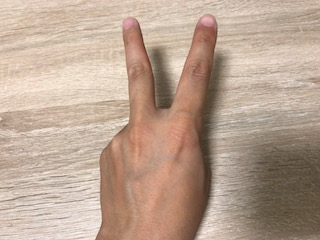

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
display_jpeg(IPImage('datasets/choki/choki_01.jpg'))

## 教師データを訓練データ（Train Data）とテストデータ（Validation Data）に分割

教師データのディレクトリと、ターゲットとなるディレクトリ（この下に訓練データのディレクトリと検証データのディレクトリが生成される）を指定します。

In [ ]:
dataset_original_dir = 'datasets'
dataset_root_dir = 'target_datasets'

教師データを訓練データのディレクトリ(train)と検証データのディレクトリ（val）に分割するスクリプトをダウンロードします。

スクリプトのプログラムに関しては、本ノートブックの主題では無いので割愛します。興味ある方は以下のアドレスで、ソフトの中身を確認して下さい。

https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

In [ ]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

--2020-10-17 17:35:46--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2683 (2.6K) [text/plain]
Saving to: ‘split_train_val.py’

split_train_val.py  100%[===================>]   2.62K  --.-KB/s    in 0s      

2020-10-17 17:35:47 (52.7 MB/s) - ‘split_train_val.py’ saved [2683/2683]



In [ ]:
import split_train_val
split_train_val.image_dir_train_val_split(
    dataset_original_dir, dataset_root_dir, train_size=0.67)

datasets/pa copy is done
datasets/choki copy is done
datasets/gu copy is done
processing is done


In [ ]:
train_dir = 'target_datasets/train'
val_dir = 'target_datasets/val'

## ラベルファイルの作成

学習するファイルのラベルを作成します

必要なライブラリをインポートします

In [ ]:
import sys
import os
import shutil

データを保存する場所を指定します

In [ ]:
backup_dir = './model'

ラベルデータを作成します（最後に表示される class numberが画像の種類の数です）

In [ ]:
labels = [d for d in os.listdir(dataset_original_dir) \
    if os.path.isdir(os.path.join(dataset_original_dir, d))]
labels.sort()

if os.path.exists(backup_dir):
  shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
  for label in labels:
    f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

class number=3


ラベルを確認します。ラベル名（choki, gu, pa）が並んでいればOKです

In [ ]:
!cat ./model/labels.txt

choki
gu
pa


## 学習の事前準備

### ライブラリのインポート

TensorFlow 2.xのEager ModeをOFFにしてモデルを再学習する必要があります。
GradCamで可視化するためのソフトの都合です。

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

必要なライブラリをインポートします

このNotebookはTensorFlow、2.x系で動作するので、TensorFlow 2.x系を選択してインポートします。

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.3.0


続いて、他に必要なライブラリをインストールします。

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

先ほど作成したラベルファイルから、ラベル情報を読み込みます

In [ ]:
labels = []
with open(backup_dir + '/labels.txt','r') as f:
  for line in f:
    labels.append(line.rstrip())
print(labels)

NUM_CLASSES = len(labels)

['choki', 'gu', 'pa']


### 学習のハイパーパラメータの設定

学習のハイパーパラメータの設定をします

In [ ]:
# 学習率
LEARNING_RATE = 0.001
# エポック（世代数）
EPOCHS = 20
# バッチサイズ
BATCH_SIZE = 8

### データセットの前処理

データセットの前処理（変換）をします

In [ ]:
IMAGE_SIZE = 64

train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

Found 111 images belonging to 3 classes.
Found 56 images belonging to 3 classes.


### 前処理の確認

　イテレータを使うと、まとまったデータを順々に処理するのに便利なので、大量のデータを処理するディープラーニングではよく使われます。イテレータに関してより詳しく知りたい方は、Pythonの入門書やWebでの情報を調べてみて下さい。

ここでは、イテレータの中身を確認しておきます。イテレータの中身を確認するには next関数を使うのが簡単です。

In [ ]:
(image_data,label_data) = train_data.next()
print(image_data)
print(label_data)

[[[[0.9176471  0.8313726  0.7490196 ]
   [0.76470596 0.6745098  0.6039216 ]
   [0.8941177  0.8078432  0.7254902 ]
   ...
   [0.7254902  0.6392157  0.58431375]
   [0.7372549  0.64705884 0.58431375]
   [0.7490196  0.65882355 0.5882353 ]]

  [[0.8235295  0.7372549  0.654902  ]
   [0.89019614 0.8000001  0.7294118 ]
   [0.83921576 0.75294125 0.67058825]
   ...
   [0.75294125 0.6627451  0.5921569 ]
   [0.74509805 0.6627451  0.59607846]
   [0.8313726  0.7490196  0.68235296]]

  [[0.81568635 0.7294118  0.64705884]
   [0.8431373  0.75294125 0.68235296]
   [0.7372549  0.6509804  0.5686275 ]
   ...
   [0.7725491  0.68235296 0.6117647 ]
   [0.7176471  0.63529414 0.56078434]
   [0.72156864 0.6392157  0.57254905]]

  ...

  [[0.9176471  0.85098046 0.8196079 ]
   [0.854902   0.78823537 0.7490196 ]
   [0.8705883  0.80392164 0.76470596]
   ...
   [0.34117648 0.2784314  0.21568629]
   [0.3647059  0.3019608  0.2392157 ]
   [0.3647059  0.3019608  0.2392157 ]]

  [[0.77647066 0.7019608  0.64705884]
   [0.7

In [ ]:
print(image_data.shape)
print(label_data.shape)

(8, 64, 64, 3)
(8, 3)


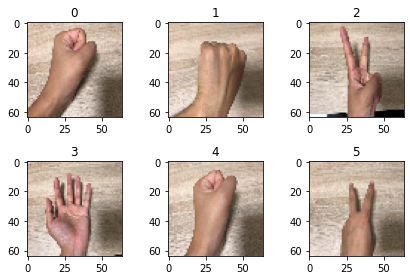

In [ ]:
import matplotlib.pyplot as plt
image_numb = 6 # 3の倍数を指定してください
for i in range(0, image_numb):
  ax = plt.subplot(image_numb // 3, 3, i + 1)
  plt.tight_layout()
  ax.set_title(str(i))
  plt.imshow(image_data[i])

## AIモデル作成

ニューラルネットワーク（CNN）モデルを作成します
これは、KerasのMNISTと呼ばれる文字認識に使われるニューラルネットワークモデルをベースにしています。

MNISTは、0,1の2値ですが、RGB画像に対応できるように改造しています。具体的には、最初の層の入力サイズを `input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)`とすることで対応しています。

https://keras.io/examples/mnist_cnn/

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)

model.compile(opt, loss='categorical_crossentropy', 
    metrics=['accuracy'])

モデルの概要を確認します

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

AIモデルの学習を行います

In [ ]:
%%time
history = model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

Epoch 1/20
13/14 [==========================>...] - ETA: 0s - batch: 6.0000 - size: 7.9231 - loss: 3.1714 - accuracy: 0.3301WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
14/14 [==============================] - 0s 24ms/step - batch: 6.5000 - size: 7.9286 - loss: 3.0256 - accuracy: 0.3153 - val_loss: 1.0805 - val_accuracy: 0.3929
Epoch 2/20
14/14 [==============================] - 0s 25ms/step - batch: 6.5000 - size: 7.9286 - loss: 1.0456 - accuracy: 0.5135 - val_loss: 1.0365 - val_accuracy: 0.4464
Epoch 3/20
14/14 [==============================] - 0s 24ms/step - batch: 6.5000 - size: 7.9286 - loss: 0.9323 - accuracy: 0.5946 - val_loss: 0.7538 - val_accuracy: 0.7857
Epoch 4/20
14/14 

## 学習結果の可視化

lossを確認します。低いほど良い性能を示します。

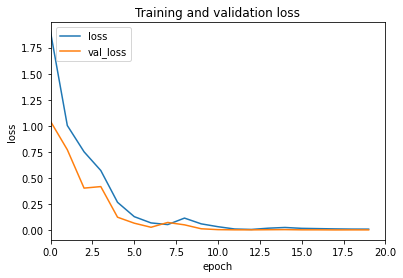

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

acc（精度）を確認します。accが訓練データでの精度で、この値が高いほど良い性能を意味します。
例えば0.5だと50%の正解率ということになります。

val_accというのが訓練に使っていないテストデータを使っての精度です。  
いわゆる、本当の精度と言われるものは、val_accの方となります。

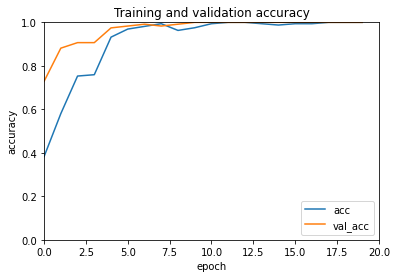

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

## 学習させたモデルを使った推定

学習させたモデルを使って、画像の推定を行います

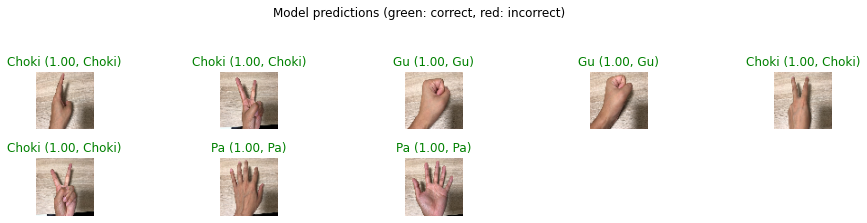

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = True
validation_data.batch_size = BATCH_SIZE

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

validation_id = np.argmax(validation_label_batch, axis=-1)
validation_label = class_names[validation_id]
predicted_batch = model.predict(validation_image_batch)

# Returns the indices of the maximum values along a given axis
predicted_id = np.argmax(predicted_batch, axis=-1)

# Return the maximum values along a given axis
predicted_score = np.max(predicted_batch, axis=-1)

predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 5, n + 1)

  # Convert the range from -1 to 1 to the range from 0 to 1
  plt.imshow(np.array(validation_image_batch[n]*255,np.int32))
  color = 'green' if predicted_id[n] == validation_id[n] else 'red'
  predicted_label = predicted_label_batch[n].title()
  plt.title(predicted_label + ' ({:.2f}, {})'.format(
      predicted_score[n], validation_label[n]), color=color)
  plt.axis('off')

_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

Instructions for updating:
Please use Model.predict, which supports generators.


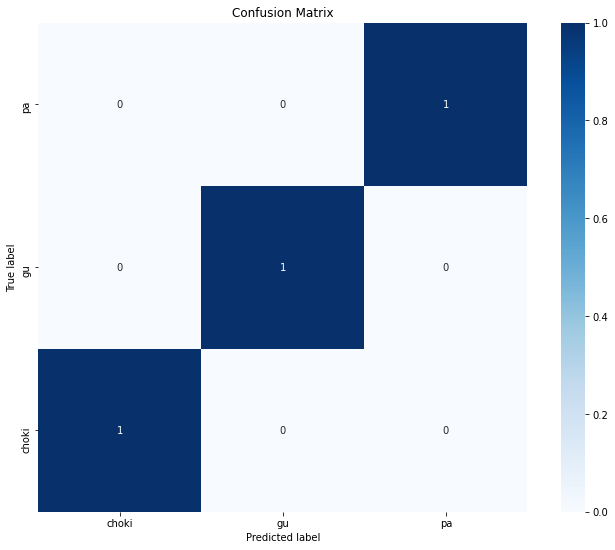

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_data.reset()
validation_data.shuffle =  False
validation_data.batch_size = 1

# Retrieve the first batch from the validation data
for validation_image_batch, validation_label_batch in validation_data:
  break

predicted = model.predict_generator(validation_data, steps=validation_data.n)
predicted_classes = np.argmax(predicted, axis=-1)

# Apply normalization
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(validation_data.classes, predicted_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 9))

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://matplotlib.org/users/colormaps.html
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=validation_data.class_indices,
            yticklabels=validation_data.class_indices)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.show()

## Grad-CAMでの可視化
Grad-CAMでの可視化を実施します。

モデルを確認します。

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

Grad-CAMに必要なライブラリをインポートします。

In [ ]:
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
import cv2

Grad-CAMの計算部分を定義します。

In [ ]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = NUM_CLASSES
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)
    conv_output = model.get_layer(layer_name).output


    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (IMAGE_SIZE, IMAGE_SIZE))
    cam = (cam - cam.mean()) / cam.std()
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR from the preprocessed image
    image = image[0, :] * 255

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)

    return np.uint8(cam), heatmap

def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    new_image = Image.fromarray(new_image)
    return new_image

def get_grad_cam(input, layer_name):
    preprocessed_input = []
    preprocessed_input.append(input)
    preprocessed_input = np.asarray(preprocessed_input)
    predictions = model.predict(preprocessed_input)
    predicted_class = np.argmax(predictions)
    cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, layer_name=layer_name)
    cam = cv2pil(cam)
    return cam

可視化するレイヤーを選択します。

In [ ]:
LAYER_NAME = 'conv2d'

Grad-CAMを使った可視化をします。

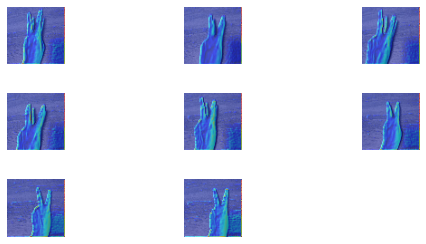

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = False
validation_data.batch_size = BATCH_SIZE

for validation_image_batch, validation_label_batch in validation_data:
  break

plt.figure(figsize=(9, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 3, n + 1)

  plt.imshow(get_grad_cam(validation_image_batch[n], layer_name=LAYER_NAME))

  plt.axis('off')

別の層の可視化を行います。

In [ ]:
LAYER_NAME = 'conv2d_1'

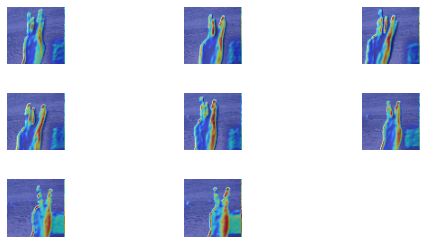

In [ ]:
# Get the ordered list of class names:
import PIL.Image as Image
class_names = validation_data.class_indices.items()
class_names = np.array([key.title() for key, value in class_names])

validation_data.reset()
validation_data.shuffle = False
validation_data.batch_size = BATCH_SIZE

for validation_image_batch, validation_label_batch in validation_data:
  break

plt.figure(figsize=(9, 9))
plt.subplots_adjust(hspace=0.5)

# Display the classification results for the first 30 images
for n in range(min(validation_image_batch.shape[0], 30)):
  plt.subplot(6, 3, n + 1)

  plt.imshow(get_grad_cam(validation_image_batch[n], layer_name=LAYER_NAME))

  plt.axis('off')

## 学習モデルの保存と読み込み


Google Colaboratory上のファイルは、自動的に消えてしまうのでファイルを保存します

In [ ]:
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls model

labels.txt  my_model.h5


In [ ]:
!cp './model/my_model.h5' '/content/drive/My Drive'
!cp './model/labels.txt' '/content/drive/My Drive'

あとは、Google Drive経由でファイルをダウンロードします。

## まとめ

ここまでで、学習から推論は完了です。

発展として、以下を実施してどうなるか確認してみましょう。

- ハイパーパラメータを変更して学習の変更度合いを確認
- 教師データをジャンケン以外のものにしてみる

## 参考リンク

以下は多くを参考にした情報です。

CNN構造
- http://aidiary.hatenablog.com/entry/20161127/1480240182


データN増し
- https://github.com/bohemian916/deeplearning_tool/blob/master/increase_picture.py

GradCam
- https://github.com/shinmura0/Python-study-group/blob/master/Text3.ipynb

GradCam Confusion Matrix
- https://colab.research.google.com/drive/1mirG8BSoB3k87mh-qyY3-8-ZXj0XB6h6

TensorFlow 2.x対応
- http://tensorflow.classcat.com/2019/11/04/tf20-tutorials-images-classification/

乱数(Seed)固定
- https://scrapbox.io/nwtgck/Tensorflow+Keras%E3%81%A7%E5%86%8D%E7%8F%BE%E6%80%A7%E3%81%AE%E3%81%82%E3%82%8B%E4%B9%B1%E6%95%B0%E3%82%92%E7%94%9F%E6%88%90%E3%81%99%E3%82%8B_-_%E3%82%B7%E3%83%BC%E3%83%89%E5%9B%BA%E5%AE%9A
- https://qiita.com/okotaku/items/8d682a11d8f2370684c9


以下は、ヒントとなった情報
- http://aidiary.hatenablog.com/entry/20161212/1481549365
- https://qiita.com/yampy/items/706d44417c433e68db0d
- https://qiita.com/haru1977/items/17833e508fe07c004119
- http://hatakazu.hatenablog.com/entry/2017/06/08/045953
- https://qiita.com/Mco7777/items/2b76aba1bae35f2623ea

